# 🔍 YOLO를 활용한 실시간 객체 탐지

## 🎯 학습 목표
- **YOLO(You Only Look Once)** 알고리즘의 원리 이해
- **실시간 객체 탐지** 시스템 구현
- **컴퓨터 비전**의 실무 활용 경험
- **개인 이미지**를 활용한 맞춤형 프로젝트

## 💡 YOLO란?
**YOLO(You Only Look Once)**는 이미지를 한 번만 보고 여러 객체를 동시에 탐지하는 혁신적인 알고리즘입니다.

### 🌟 YOLO의 특징
- **빠른 속도**: 실시간 처리 가능 (30+ FPS)
- **높은 정확도**: 최신 딥러닝 기술 적용
- **쉬운 사용**: 사전 훈련된 모델 제공

----
## 🔧 환경 설정 및 라이브러리 설치

### 📦 필요한 라이브러리
- **ultralytics**: YOLO 최신 버전 (YOLOv8)
- **opencv-python**: 이미지/비디오 처리
- **pillow**: 이미지 편집
- **matplotlib**: 결과 시각화
- **torch**: 딥러닝 프레임워크

In [37]:
# ultralytics 설치 (YOLOv8 포함) – 약 1분
!pip install ultralytics>=8.0.0 ipywidgets matplotlib seaborn


In [38]:
import ultralytics
from ultralytics import YOLO
import torch, os, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
print('Ultralytics version:', ultralytics.__version__)
print('PyTorch version    :', torch.__version__)
print('CUDA available     :', torch.cuda.is_available())
device = 0 if torch.cuda.is_available() else 'cpu'


Ultralytics version: 8.3.160
PyTorch version    : 2.6.0+cu124
CUDA available     : True



## 2. 데이터셋 – COCO128  📊

- **COCO128**은 COCO 2017 train split 중 앞 128장을 뽑은 소규모 튜토리얼용 데이터셋
- 자동으로 다운로드·전처리


In [ ]:
# ⬇️ coco128 데이터셋 다운로드 (ZIP 방식, 울트라리틱스 함수 불필요)
import urllib.request, zipfile, os, pathlib, shutil

url = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip"
root = pathlib.Path('datasets')
root.mkdir(parents=True, exist_ok=True)
zip_path = root / 'coco128.zip'

print("Downloading coco128.zip ...")
urllib.request.urlretrieve(url, zip_path)
print("Download complete! Extracting...")

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(root)

zip_path.unlink()  # delete zip file
print("Dataset ready at", root / 'coco128')

In [ ]:
import random, glob, cv2, matplotlib.pyplot as plt

train_imgs = glob.glob('datasets/coco128/images/train2017/*.jpg')
samples = random.sample(train_imgs, 4)

plt.figure(figsize=(8,8))
for i, img_path in enumerate(samples):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(img_path.split('/')[-1], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()



## 3. 모델 학습 📚

### mAP (mean Average Precision) 🏆

mAP는 객체 탐지(Object Detection) 모델의 정확도(Precision)와 재현율(Recall)을 종합적으로 평가하는 대표 지표, 하나의 클래스에 대해 IoU(Intersection‑over‑Union) 임계값을 고정한 뒤 Precision–Recall 곡선 아래 넓이(Area Under Curve)를 적분하면 AP(Average Precision) 가 되고, 이를 모든 클래스에 대해 평균 내면 mAP가 됩니다.

#### AP 계산 절차 🎯

1. 예측 박스(Confidence 내림차순)와 GT 박스 매칭
2. IoU ≥ 임계값(예: 0.5)이면 TP, 그렇지 않으면 FP
3. 누적 TP·FP로 Precision, Recall을 계산
4. PR 곡선을 0 → 1까지 101 점(0, 0.01, … 1.0)에서 샘플링해 적분

#### Precision & Recall 계산 🎯

- Precision (정밀도) = TP / (TP + FP)
    - 모델이 '검출했다' 고 예측한 것 중 실제로 맞은 비율 ✅

- Recall (재현율) = TP / (TP + FN)
    - GT(Ground Truth, 정답) 중에서 모델이 놓치지 않고 검출한 비율  🔍

### Confidence & IoU 🎯
- Confidence : 모델이 객체를 얼마나 확신하여 예측했는지를 나타내는 정도 (1에 가까울수록 확신)
- IoU : GT(정답)와 예측한 객체의 Box의 겹치는 영역을 전체 합집합으로 나눈 값 (1에 가까울수록 완전 일치)

### 값 해석하기 ✅

- 1.0 (100 %)에 가까울수록 검출 성능이 좋음 🌟

In [51]:
# ‼️ 에포크 수를 늘릴수록 성능은 좋아지지만 시간이 오래 걸립니다.
model = YOLO('yolov8n.pt')        # nano 모델 (≈3.2 M 파라미터)
results = model.train(
    data='coco128.yaml',          # 내장 데이터셋 경로
    epochs=5,                     # 데모용 3 epoch
    imgsz=640,
    device=device
)

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train13, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

train: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 355.1±130.6 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train13
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.58G      1.156      1.519      1.226        172        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        128        929      0.649      0.536      0.613      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.38G       1.21      1.439      1.243        231        640: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        128        929      0.654      0.551      0.628      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.39G      1.161      1.376      1.252        192        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        128        929      0.663       0.56      0.636      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       3.4G      1.171      1.332      1.234        215        640: 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        128        929      0.653      0.582      0.646      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       3.4G      1.195      1.349      1.273        236        640: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        128        929      0.678      0.567      0.649      0.485



5 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 6.5MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        128        929      0.678      0.567      0.649      0.485
                person         61        254      0.824      0.685      0.774      0.549
               bicycle          3          6      0.483      0.333      0.388      0.289
                   car         12         46      0.834      0.217      0.287      0.186
            motorcycle          4          5      0.687      0.884      0.938      0.754
              airplane          5          6      0.833      0.831      0.903      0.689
                   bus          5          7      0.784      0.714      0.722      0.676
                 train          3          3      0.725      0.898      0.913       0.78
                 truck          5         12          1      0.374      0.537      0.351
                  boat          2          6      0.411      0.244      0.469      0.311
         traffic light          4         14      0.695      0.167      0.202      0.139
             stop sig

## 4. 예측 결과 시각화 📚


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 3 persons, 1 bus, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


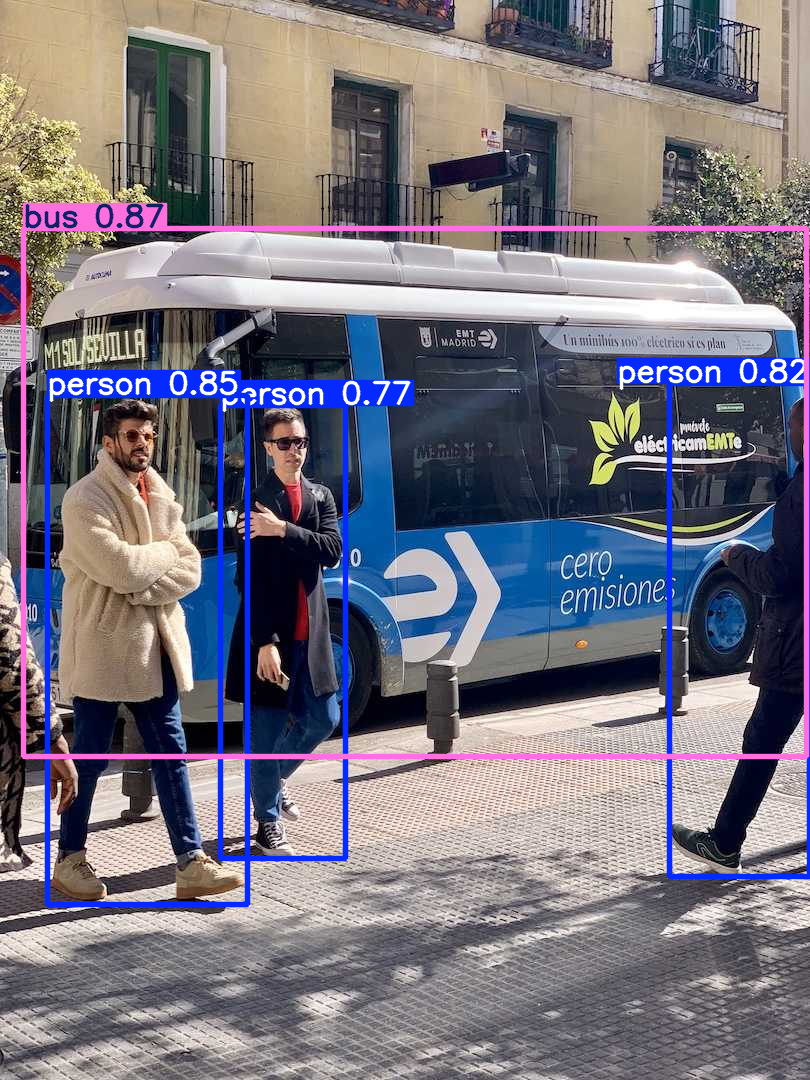

In [53]:
from PIL import Image

sample_img = 'https://ultralytics.com/images/bus.jpg'  # 예제 이미지
pred = model.predict(sample_img, save=False, imgsz=640, conf=0.50)
res = pred[0]

#시각화
img_bgr = res.plot(boxes=True, masks=True, probs=False, labels=True)
img_rgb = Image.fromarray(img_bgr[..., ::-1])
display(img_rgb)

## 5. 학습 곡선 분석 📈

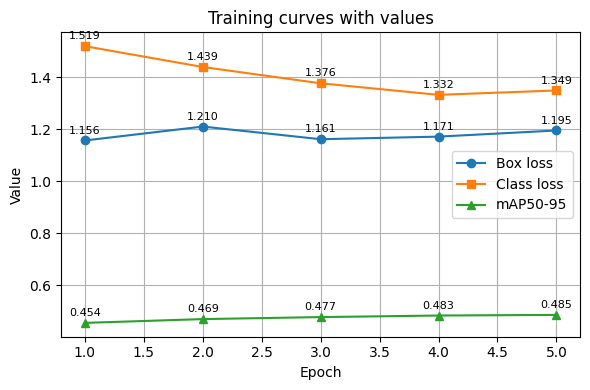

In [60]:
logfile = 'runs/detect/train/results.csv'
df = pd.read_csv(logfile)

plt.figure(figsize=(6,4))
# 플롯
plt.plot(df['epoch'], df['train/box_loss'], marker='o', label='Box loss')
plt.plot(df['epoch'], df['train/cls_loss'], marker='s', label='Class loss')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], marker='^', label='mAP50-95')

# 라벨 추가
for x, y in zip(df['epoch'], df['train/box_loss']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=8)
for x, y in zip(df['epoch'], df['train/cls_loss']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=8)
for x, y in zip(df['epoch'], df['metrics/mAP50-95(B)']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=8)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training curves with values')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. 클래스별 혼동 행렬

### 혼동행렬 (Confusion Matrix란?)

#### 정의

Confusion Matrix는 TP(True Positive), FP(False Positive), FN(False Negative) 를 행렬로 시각화해 모델이 어떤 오류를 자주 내는지 한눈에 보여줍니다.

- 오검출(FP) 많은 클래스 → Confidence Threshold↑    
- 미검출(FN) 많은 클래스 → 데이터 증강·라벨 보정    
- 클래스 간 혼동 확인 → 유사 클래스 병합/분리 검토    

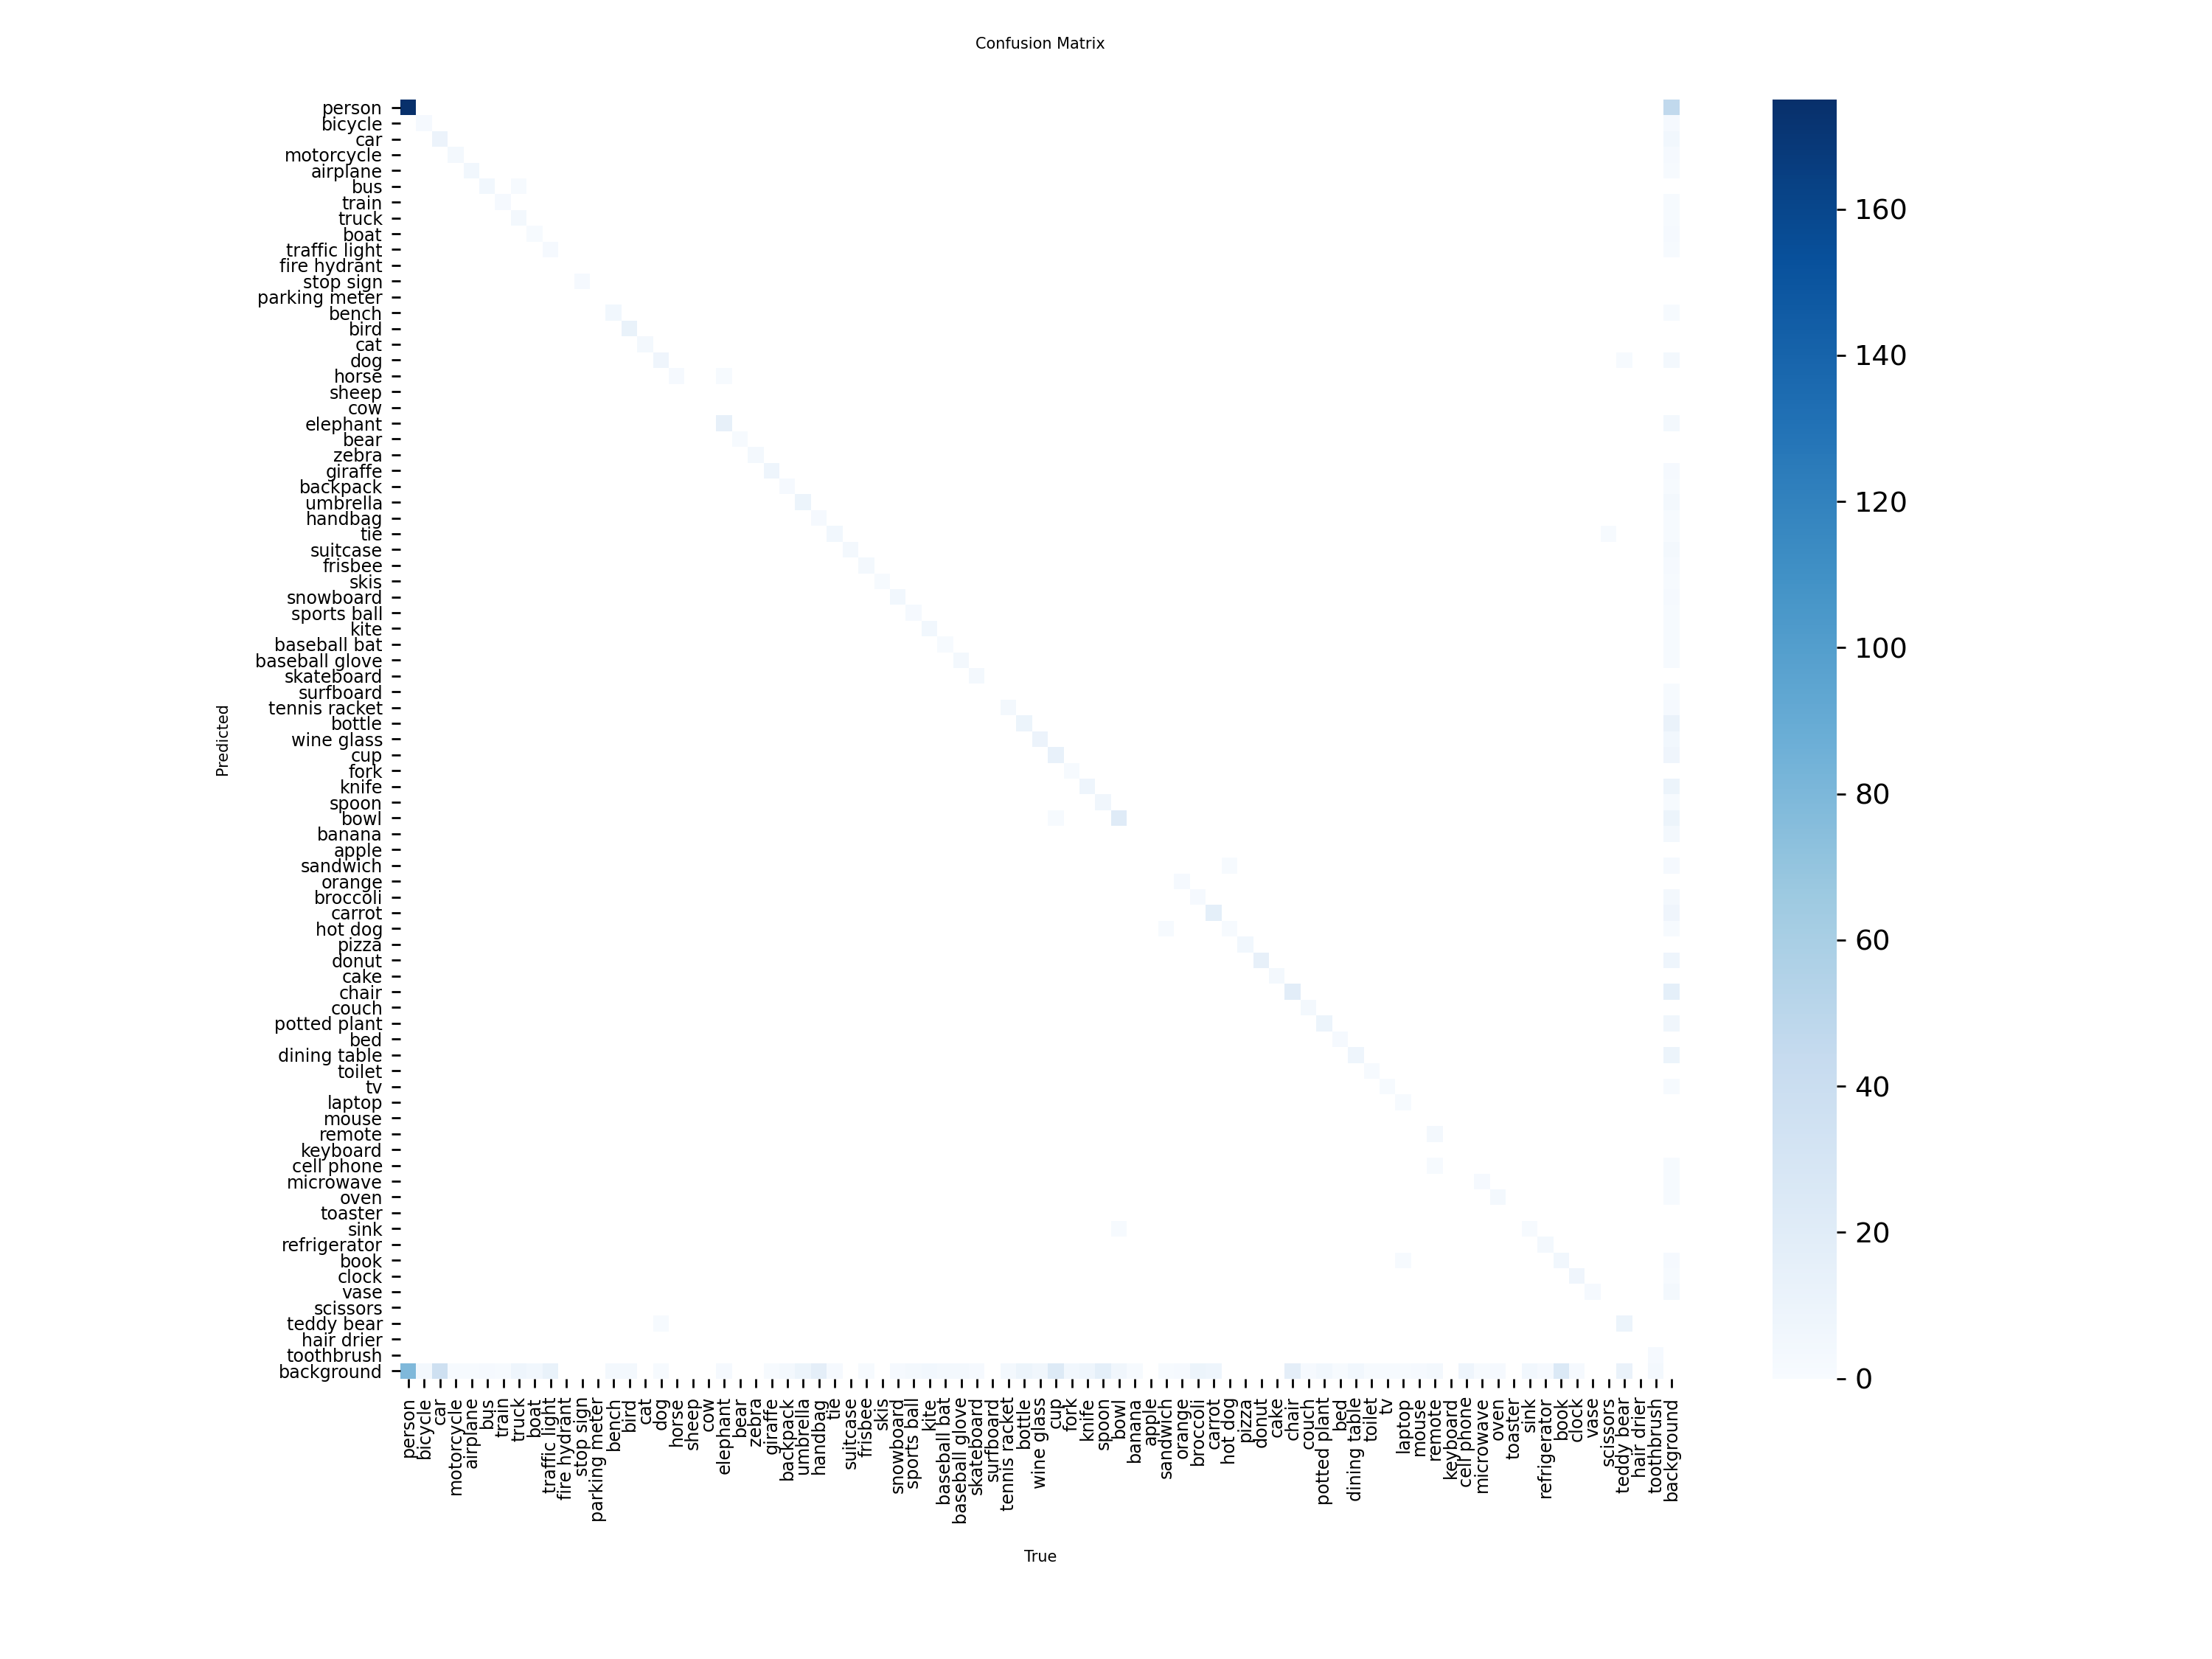

In [61]:
# metrics 객체에 confusion_matrix 속성이 포함됨 (이미지 파일)
cm_path = 'runs/detect/train/confusion_matrix.png'
if os.path.exists(cm_path):
    from IPython.display import Image
    display(Image(filename=cm_path))
else:
    print("Confusion matrix 이미지를 찾지 못했습니다.")



## 8. Future work  
1. **에포크·배치 크기 조정** – 더 많은 학습으로 성능 향상 시도  
2. **자체 데이터셋 사용** – `data=` 항목에 여러분의 YAML 설정 파일 지정  
3. **모델 크기 실험** – `yolov8s.pt`, `yolov8m.pt`, `yolov8l.pt` 등 사용해 보기  
4. **하이퍼파라미터 튜닝** – `lr0`, `weight_decay` 등 인자 튜닝으로 모델 성능 향상

---------
### Text-to-Image 생성 모델 (허깅페이스) 🖼️

- 허깅페이스란?
- Text-to-image 생성 모델이란?

### 1. 환경구성

In [ ]:
# diffusers, accelerate, transformers 설치 – 약 1분
!pip install --upgrade diffusers[torch] transformers accelerate safetensors pillow


In [63]:
from huggingface_hub import login
login()


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)


----
### 이미지 생성 파라미터

- Prompt / Negative Prompt : 모델의 ‘명령문’. 가장 큰 영향도를 갖습니다.
- Seed : 난수 초기값. 같은 시드는 동일 결과 재현을 가능하게 합니다.
- Guidance Scale (CFG) : 프롬프트를 얼마나 강하게 따를지(보통 5 – 15, SD 기본 7.5 정도).
- Inference Steps : 확산 단계 수. Steps↑ → 세부 묘사 향상, 연산 시간 증가(20 – 50 권장).

튜닝 팁
- 하나씩 바꿔보기(A/B test) → 변경이 품질에 미친 영향 파악이 쉬움
- Seed 고정 + 파라미터만 변경 → 결과 시각적 비교가 명확

  0%|          | 0/30 [00:00<?, ?it/s]

Saved to generated.png


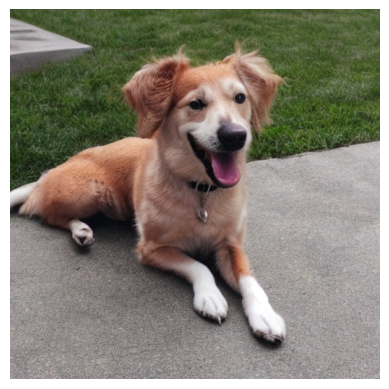

In [72]:
# 시드 고정
seed = 107
generator = torch.Generator(device="cuda").manual_seed(seed)

prompt = "a cute dog, realistic"
image = pipe(
    prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

# 결과 보기
import matplotlib.pyplot as plt
plt.imshow(image); plt.axis('off')

#### 학습한 모델로 생성된 이미지 추론하기


0: 640x640 1 dog, 25.5ms
Speed: 5.1ms preprocess, 25.5ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)


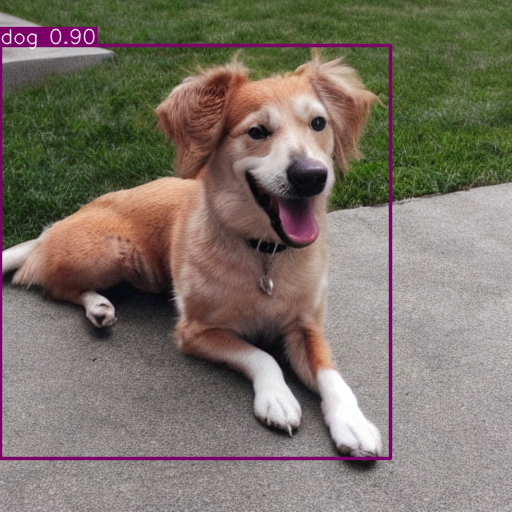

In [74]:
from PIL import Image

pred = model.predict(image, save=False, imgsz=640, conf=0.50)
res = pred[0]

#시각화
img_bgr = res.plot(boxes=True, masks=True, probs=False, labels=True)
img_rgb = Image.fromarray(img_bgr[..., ::-1])
display(img_rgb)

#### 이미지 생성 모델의 활용

1. 데이터 증강 : 검출하기 어려운 각도·배경·조명 상태 이미지를 합성해 YOLO 학습 데이터에 추가 ➜ 특히 소수 클래스 균형 개선.

2. Rare‑case 시뮬레이션 : 실제 촬영이 힘든 위험·야간·악천후 상황을 가상 생성.

3. 컨셉 아트·스토리보드 : 제품·UI mock‑up, 광고·마케팅 크리에이티브 빠른 프로토타입.

4. 교육·연구 : 모델 베이스라인 구축, Zero‑shot·Few‑shot 실험용 synthetic data.